(sec_prod2vec)=
# Instacart Product2vec

## Giới thiệu

[Instacart.com](https://www.instacart.com/) là trang web cho phép người dùng mua bán thực phẩm tươi và các vật phẩm gia dụng online. Một nhân viên giao hàng sẽ đi mua hàng giúp người dùng và giao trong thời gian rất ngắn. Năm 2017, instacart công bố một bộ dữ liệu và tổ chức [một cuộc thi trên Kaggle](https://www.kaggle.com/c/instacart-market-basket-analysis). Cuộc thi này yêu cầu người chơi dự đoán những sản phẩm mà người dùng sẽ mua ở một thời điểm nhất định dựa trên những đơn hàng trước đó của họ và các người dùng khác. Một vài thông số về bộ dữ liệu này có thể được tìm thấy tại bài báo [3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2).

Việc có được embedding của các sản phẩm sẽ rất hữu ích trong việc gợi ý những sản phẩm _tương tự_ cho người dùng dựa trên thói quen của họ. Trong mục này, chúng ta sẽ áp dụng ý tưởng của word2vec để xây dựng một mô hình _product2vec_ học các embedding từ dữ liệu huấn luyện.

Có một điểm thú vị là dữ liệu cung cấp các đơn hàng (order) và thứ tự các loại sản phẩm (product) trong đơn hàng đó. Nếu người dùng trực tiếp mua ở cửa hàng, thứ tự mua hàng có thể bị xáo trộn trong quá trình thanh toán vì tất cả đã được cho vào một giỏ. Trong trường hợp này, do người dùng mua hàng online nên hệ thống có thể lưu lại được thứ tự các mặt hàng mà họ đặt vào "giỏ".

Nếu ta coi mỗi sản phẩm là một từ thì mỗi đơn hàng có thể được coi là một câu văn. Những sản phẩm gần nhau trong thứ tứ đặt hàng thường có mối quan hệ ngữ cảnh nào đó. Chẳng hạn, nếu hai sản phẩm đầu tiên được cho vào giỏ là "bún" và "đậu phụ" thì các sản phẩm tiếp theo nhiều khả năng cao là "mắm tôm", "rau sống", "chanh". Nếu biết các sản phẩm ngữ cảnh là "bún", "đậu phụ", "rau sống" và "chanh", hệ thống sẽ dựa trên dữ liệu trong quá khứ để tính xác suất sản phẩm đích là "mắm tôm". (Tất nhiên ví dụ về các sản phẩm này không nằm trong bộ dữ liệu)

Bộ dữ liệu này cũng có thể được tìm thấy tại [dataset repo](https://github.com/tiepvupsu/tabml_data/tree/master/instacart) của cuốn sách này.


Chúng ta cùng triển khai code python cho việc xây dựng embedding cho các sản phẩm. Việc huấn luyện mô hình được thực hiện dựa trên thư viện [pytorch-lightning](https://www.pytorchlightning.ai/).

## Tiền xử lý dữ liệu

Trước hết chúng ta khai báo các thư viện cần thiết và đặt `seed` cho các thành phần ngẫu nhiên.

In [1]:
from collections import Counter
from dataclasses import dataclass
import random
from typing import List, Dict, Tuple

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from sklearn.decomposition import PCA
import torch
from torch import nn
import torch.multiprocessing
from torch.utils.data import DataLoader, Dataset
import tqdm

from tabml.utils import embedding


GLOBAL_SEED = 42  # number of life
torch.manual_seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

Tiếp theo ta tải dữ liệu của những đơn hàng trước đây trong `order_products__train.csv`. File `order_products__prior.csv` chứa nhiều hơn những đơn hàng trong quá khứ và có thể giúp các embedding có độ chính xác tốt hơn; tuy nhiên, trong ví dụ này chúng ta sẽ sử dụng tập dữ liệu nhỏ hơn để kiểm tra tính khả thi của thuật toán. Bạn đọ có thể sử dụng thêm cả `order_products__prior.csv` để có kết quả tốt hơn. Việc thay đổi code không quá phức tạp.

In [2]:
instacart_path = (
    "https://media.githubusercontent.com/media/tiepvupsu/tabml_data/master/instacart/"
)

order_df = pd.read_csv(instacart_path + "order_products__train.csv")
print(order_df.info())
order_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB
None


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


Có tổng cộng 1384617 sản phẩm trong các đơn hàng kể cả lặp. Cột `order_id`, `product_id`, `add_to_cart_order` lần lượ là mã đơn, mã sản phẩm, và thứ tự của sản phẩm trong đơn. Ta cần chuyển dữ liệu này về dạng một danh sách các đơn hàng, mỗi đơn là một danh sách các mã sản phẩm theo thứ tự chúng được đặt vào giỏ hàng.

In [3]:
def get_list_orders(order_df: pd.DataFrame) -> List[List[int]]:
    order_df = order_df.sort_values(by=["order_id", "add_to_cart_order"])
    return order_df.groupby("order_id")["product_id"].apply(list).tolist()

all_orders = get_list_orders(order_df)
print(f"Number of orders: {len(all_orders)}")
print(f"First 3 orders: {all_orders[:3]}")

Number of orders: 131209
First 3 orders: [[49302, 11109, 10246, 49683, 43633, 13176, 47209, 22035], [39612, 19660, 49235, 43086, 46620, 34497, 48679, 46979], [11913, 18159, 4461, 21616, 23622, 32433, 28842, 42625, 39693]]


Như vậy có tổng cộng 131209 đơn hàng. Trong mỗi đơn hàng là các mã sản phẩm. Ta sẽ lọc bỏ đi các đơn hàng chỉ có một sản phẩm vì chúng không tạo ra các "ngữ cảnh" cho việc huấn luyện.

In [4]:
min_product_per_order = 2
orders = [order for order in all_orders if len(order) >= min_product_per_order]
print(f"Number of orders with at least {min_product_per_order} products: {len(orders)}")

Number of orders with at least 2 products: 124364


Ta cần biết tên của từng sản phẩm để kiểm tra chất lượng của các embedding thu được ở cuối.

Thông tin sản phẩm được lưu ở file `products.csv`.

In [5]:
product_df = pd.read_csv(
    instacart_path + "products.csv", usecols=["product_id", "product_name"]
)
product_df.head(5)

,product_id,product_name
0,1,Chocolate Sandwich Cookies
1,2,All-Seasons Salt
2,3,Robust Golden Unsweetened Oolong Tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...
4,5,Green Chile Anytime Sauce


Ta sẽ xây dựng một ánh xạ giữa mã sản phẩm và tên sản phẩm để tiện tra cứu về sau:

In [6]:
# creat a mapping between product_id and product_naem
product_name_by_id = product_df.set_index("product_id").to_dict()["product_name"]
print(f"Number of product: {len(product_name_by_id)}")

Number of product: 49688


Ta sẽ chỉ quan tâm tới các sản phẩm xuất hiện trong các đơn hàng ở `orders`. Đoạn code dưới đây xây dựng các bộ ánh xạ giữa các mã sản phẩm, tên sản phẩm và chỉ số của các sản phẩm trong "từ điển". Thứ tự của các sản phẩm không quan trọng nhưng ta cần biết rõ sản phẩm nào có thứ tự nào trong từ điển cũng như trong ma trận embedding thu được.

In [7]:
# All products appearing in orders
ordered_products = set([product for order in orders for product in order])
product_mapping = dict()
# build mappings: product_id -> product_index, product_index -> product_name
product_mapping["index_by_id"] = dict()
product_mapping["name_by_index"] = dict()
ind = 0
for ind, product_id in enumerate(ordered_products):
    product_name = product_name_by_id[product_id]
    product_mapping["index_by_id"][product_id] = ind
    product_mapping["name_by_index"][ind] = product_name

Vì mỗi `order` hiện tại là một danh sách các mã sản phẩm, ta cần đổi nó về thứ tự sản phẩm trong từ điển:

In [8]:
indexed_orders = [
    [product_mapping["index_by_id"][product_id] for product_id in order]
    for order in orders
]

## Xây dựng dữ liệu huấn luyện

Với mỗi sản phẩm đích `targer_product`, ta sẽ xây dựng một bộ ba `(targer_product, context_products, labels)`. Trong đó:

* `context_products` là mảng gồm các sản phẩm ngữ cảnh dương (`positive_context_products`) VÀ các sản phẩm không trong ngữ cảnh đó tìm được qua phép lấy mẫu âm, tạm gọi là những sản phẩm ngữ cảnh âm (`negative_context_products`).

* `labels` là một mảng nhị phân có độ dài bằng với `context_products` để phân biệt `positive_context_products` và `negative_context_products`. Mảng nhị phân này cũng được dùng để tính giá trị hàm mất mát.

Để có thể huấn luyện dưới dạng batch, độ dài của `context_products` cần phải giống nhau giữa các mẫu huấn luyện. Do số sản phẩm ngữ cảnh có độ dài biến đổi tùy thuộc vào vị trí của sản phẩm đích trong đơn hàng, ta sẽ chọn số lượng sản phẩm _âm_ sao cho tổng số phần tử trong `context_products` bằng hằng số.

Trước tiên, ta đi xây dựng những thành phần _cố định_ của mỗi mẫu huấn luyện. Các thành phần không cố định từ phép lấy mẫu âm sẽ được thêm vào trong quá trình huấn luyện.

### Xây dựng dữ liệu ngữ cảnh dương

In [9]:
context_window = 5
# total number of context products, including positive and negative products
all_targets = []
all_positive_contexts = []
for order in indexed_orders:
    for i, product in enumerate(order):
        all_targets.append(product)
        positive_context = [
            order[j]
            for j in range(
                max(0, i - context_window), min(len(order), i + context_window + 1)
            )
            if j != i
        ]
        all_positive_contexts.append(positive_context)

print("Sample order:", indexed_orders[0])
for i in range(3):
    print(f"Target product: {all_targets[i]}", end = ", ")
    print(f"Positive context products: {all_positive_contexts[i]}")

Sample order: [38764, 8736, 8063, 39057, 34290, 10349, 37106, 17371]
Target product: 38764, Positive context products: [8736, 8063, 39057, 34290, 10349]
Target product: 8736, Positive context products: [38764, 8063, 39057, 34290, 10349, 37106]
Target product: 8063, Positive context products: [38764, 8736, 39057, 34290, 10349, 37106, 17371]


### Xây dựng bộ lấy mẫu âm

Theo bài báo thứ hai về Word2vec, các mẫu âm được lấy mẫu không tuân theo phân phối đều mà tuân theo tần suất xuất hiện của từ đó trong toàn bộ các câu. Cụ thể, nếu một từ $w_i$ xuất hiện $f(w_i)$ lần thì trọng số lấy mẫu của nó tỉ lệ với $f(w_i)^{3/4}$. Con số $3/4$ là một con số thực nghiệm, bạn đọc có thể thử nghiệm với các trọng số khác tùy thuộc vào bài toán và dữ liệu. Với bài toán này, $0.5$ mang lại kết quả tương đối hợp lý.

In [10]:
def get_sampling_weights(orders):
    product_freq = Counter([product for order in orders for product in order])
    sampling_weights = [0 for _ in product_freq]
    for product_index, count in product_freq.items():
        sampling_weights[product_index] = count**0.5
    return sampling_weights

sampling_weights = get_sampling_weights(indexed_orders)

Vì các hàm số của module `random` tương đối chậm, ta sẽ tạo trước một mảng chứa `pre_drawn` số mẫu đã được lấy rồi trả về từng phẩn tử của mảng đó mỗi khi được gọi.

In [11]:
class ProductSampler:
    def __init__(self, products, weights, pre_drawn=10_000_000):
        self.products = products
        self.weights = weights
        self.pre_drawn = pre_drawn
        self.pre_drawn_products = []

    def refill(self):
        self.pre_drawn_products = random.choices(
            population=self.products, weights=self.weights, k=self.pre_drawn
        )

    def draw(self):
        if not self.pre_drawn_products:
            self.refill()
        return self.pre_drawn_products.pop()


num_products = len(ordered_products)
product_sampler = ProductSampler(
    products=range(num_products),
    weights=sampling_weights,
    pre_drawn=10_000_000,
)

print("Sampling samples:", [product_sampler.draw() for _ in range(10)])

Sampling samples: [18129, 15355, 20263, 23956, 38661, 29016, 34084, 18226, 24946, 17815]


### DataLoader cho pytorch

Tiếp theo, ta xây dựng một data loader tạo ra các mẫu huấn luyện mô hình. Mỗi lần được gọi, data loader này sẽ trả về một sản phẩm đích, một bộ các sản phẩm ngữ cảnh -- bao gồm ngữ cảnh dương và âm, và các nhãn tương ứng.

In [12]:
@dataclass
class TargetContextDataset(Dataset):
    all_targets: List[int]
    all_positive_contexts: List[List[int]]
    product_sampler: ProductSampler
    num_context_products: int = 10

    def __len__(self):
        return len(self.all_targets)

    def __getitem__(self, index):
        target = torch.IntTensor([self.all_targets[index]])
        positive_contexts = self.all_positive_contexts[index].copy()
        num_pos = len(positive_contexts)
        num_neg = self.num_context_products - len(positive_contexts)
        mask = [1] * num_pos + [0] * num_neg
        while len(positive_contexts) < self.num_context_products:
            product = self.product_sampler.draw()
            if product not in positive_contexts:
                positive_contexts.append(product)

        contexts = torch.IntTensor(positive_contexts)
        mask = torch.FloatTensor(mask)
        return target, contexts, mask


training_data = TargetContextDataset(
    all_targets, all_positive_contexts, product_sampler, num_context_products=10
)
train_dataloader = DataLoader(
    training_data, batch_size=8192, shuffle=True, num_workers=12
)

for target, context_products, labels in train_dataloader:
    print("Target:", target[0])
    print("Context products:", context_products[0])
    print("Labels:", labels[0])
    break

Target: tensor([9051], dtype=torch.int32)
Context products: tensor([31900, 23881, 19543, 21892, 25831, 22066, 34773, 11059, 16049, 18027],
       dtype=torch.int32)
Labels: tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])


## Xây dựng hàm mất mát

Mô hình mạng neural trả về một mảng các logit (trước hàm sigmoid $\sigma$) của toàn bộ các sản phẩm tương ứng với một sản phẩm đích ở đầu vào. Sau bước lấy mẫu âm, các logits ứng với những sản phẩm ngữ cảnh (dương và âm) sẽ được trích ra để tính hàm mất mát. Gọi $p_i$ là sigmoid của logit thứ $i$, hàm mất mát tại mỗi logit được cho bởi hàm cross entropy nhị phân:

$$
-y_i\log p_i - (1-y_i) \log(1 - p_i)
$$

Với $y_i = 1$ ứng với sản phẩm dương và $y_i = 0$ ứng với sản phẩm âm. Hàm mất mát ứng với mỗi sản phẩm đích là trung bình của các cross entropy nhị phân này.

Pytorch hỗ trợ hàm [`binary_cross_entropy_with_logits`](https://pytorch.org/cppdocs/api/classtorch_1_1nn_1_1_b_c_e_with_logits_loss.html#classtorch_1_1nn_1_1_b_c_e_with_logits_loss) để tính hàm mất mát này.

In [13]:
class SigmoidBCELoss(nn.Module):
    "BCEWithLogitLoss with masking on call."

    def __init__(self):
        super().__init__()

    def forward(self, inputs, label):
        inputs = torch.reshape(inputs, (inputs.shape[0], -1))
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, label, reduction="none")

        return torch.mean(out)

loss_fn = SigmoidBCELoss()
sample_logits = torch.Tensor([[100, -100], [1, 1]])
sample_labels = torch.Tensor([[1, 0], [1, 0]])
loss_fn(sample_logits, sample_labels)

tensor(0.4066)

## Xây dựng mô hình

[Pytorch-lightning](https://www.pytorchlightning.ai/) hỗ trợ rất tốt việc xây dựng mô hình và huấn luyện trong pytorch.

In [14]:
class Prod2VecModel(pl.LightningModule):
    def __init__(self, num_products, embed_size: int = 50):
        super().__init__()
        self.embed_size = embed_size
        self.embed_t = nn.Embedding(num_products, self.embed_size)
        self.embed_c = nn.Embedding(num_products, self.embed_size)

    def forward(self, targets, contexts):
        v = self.embed_t(targets)
        u = self.embed_c(contexts)
        pred = torch.bmm(v, u.permute(0, 2, 1))
        return pred

    def training_step(self, batch, batch_idx):
        targets, contexts, labels = batch
        output = self.forward(targets, contexts)
        loss = loss_fn(output, labels)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-3)
        return optimizer

## Huấn luyện mô hình

Ta sẽ xây dựng một mô hình với kích thước embedding là 100. Bạn đọc cần chỉnh `gpus` theo số GPU phù hợp.

In [15]:
embed_size = 100
model = Prod2VecModel(num_products, embed_size)
trainer = pl.Trainer(gpus=1, max_epochs=50)
trainer.fit(model, train_dataloader, train_dataloader)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


/home/tiepvu/w/tabml_book/tabml_book_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type      | Params
--------------------------------------
0 | embed_t | Embedding | 3.9 M 
1 | embed_c | Embedding | 3.9 M 
--------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.249    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

## Kiểm chứng Embedding

Sau khi huấn luyện được mô hình, ta thu được ma trận embedding `embed_t` là biểu diễn của các sản phẩm trong không gian embedding.

Chúng ta cùng làm một vài thí nghiệm với kết quả thu được.

### Tìm các sản phẩm tương tự

Cùng thử tìm các sản phẩm có chứa từ "Organic Yogurt" (sữa chua organic) và các sản phẩm tương tự nhất theo độ tương tự cosine.

In [16]:
embs_arr = model.state_dict()['embed_t.weight'].detach().numpy()

emb_nn = embedding.NearestNeighbor(embs_arr, measure="cosine")
names = [product_mapping["name_by_index"][i] for i in range(num_products)]

sub_name = "Organic Yogurt"
ids = [ind for ind, name in enumerate(names) if sub_name in name]
for ind in ids[:5]:
    print('==========')
    print(f'Similar items of "{names[ind]}":')
    nearest_ids = emb_nn.find_nearest_neighbors(embs_arr[ind, :], k=2)
    print([names[i] for i in nearest_ids])

Similar items of "Organic Yogurt Baby Food":
['Organic Yogurt Baby Food', 'Macaroni Salad']
Similar items of "Banana & Mango Organic Yogurt & Fruit Snacks ":
['Banana & Mango Organic Yogurt & Fruit Snacks\xa0', 'Organic Mixed Berry Yogurt & Fruit Snack']
Similar items of "Organic Yogurt Original Plain":
['Organic Yogurt Original Plain', 'Lactose Free Organic Whole Milk Plain Yogurt']
Similar items of "Fat Free Smooth & Creamy Plain Organic Yogurt":
['Fat Free Smooth & Creamy Plain Organic Yogurt', 'Organic Orange Juice with Pulp']
Similar items of "Cream on Top Strawberry Organic Yogurt":
['Cream on Top Strawberry Organic Yogurt', 'Organic Blueberry Cream On Top Whole Milk Yogurt']


Với mỗi sản phẩm có chứa từ "Organic Yogurt", có hai sản phẩm tương tự nhất được trả về bao gồm chính nó. Ngoài sản phẩm đầu tiên, "Maroni Salad", các sản phẩm khác đều có liên quan đến "Organic" hoặc "Yogurt". Điều này chứng tỏ các sản phẩm liên quan đến "Organic Yogurt" đã được đưa về gần nhau trong không gian embedding.

Trong quá trình huấn luyện, ta không dùng bất cứ thông tin nào của sản phẩm ngoại trừ thứ tự của chúng trong các đơn hàng. Khá là kỳ diệu!

### Minh họa embedding trong không gian hai chiều

Các embedding thu được có số chiều là 100. Để minh họa vị trí tương đối của chúng, ta đưa chúng về không gian hai chiều bằng PCA và minh họa các điểm tương ứng với mỗi sản phẩm. Chúng ta sẽ tô màu đỏ cho các sản phẩm có từ "Organic".

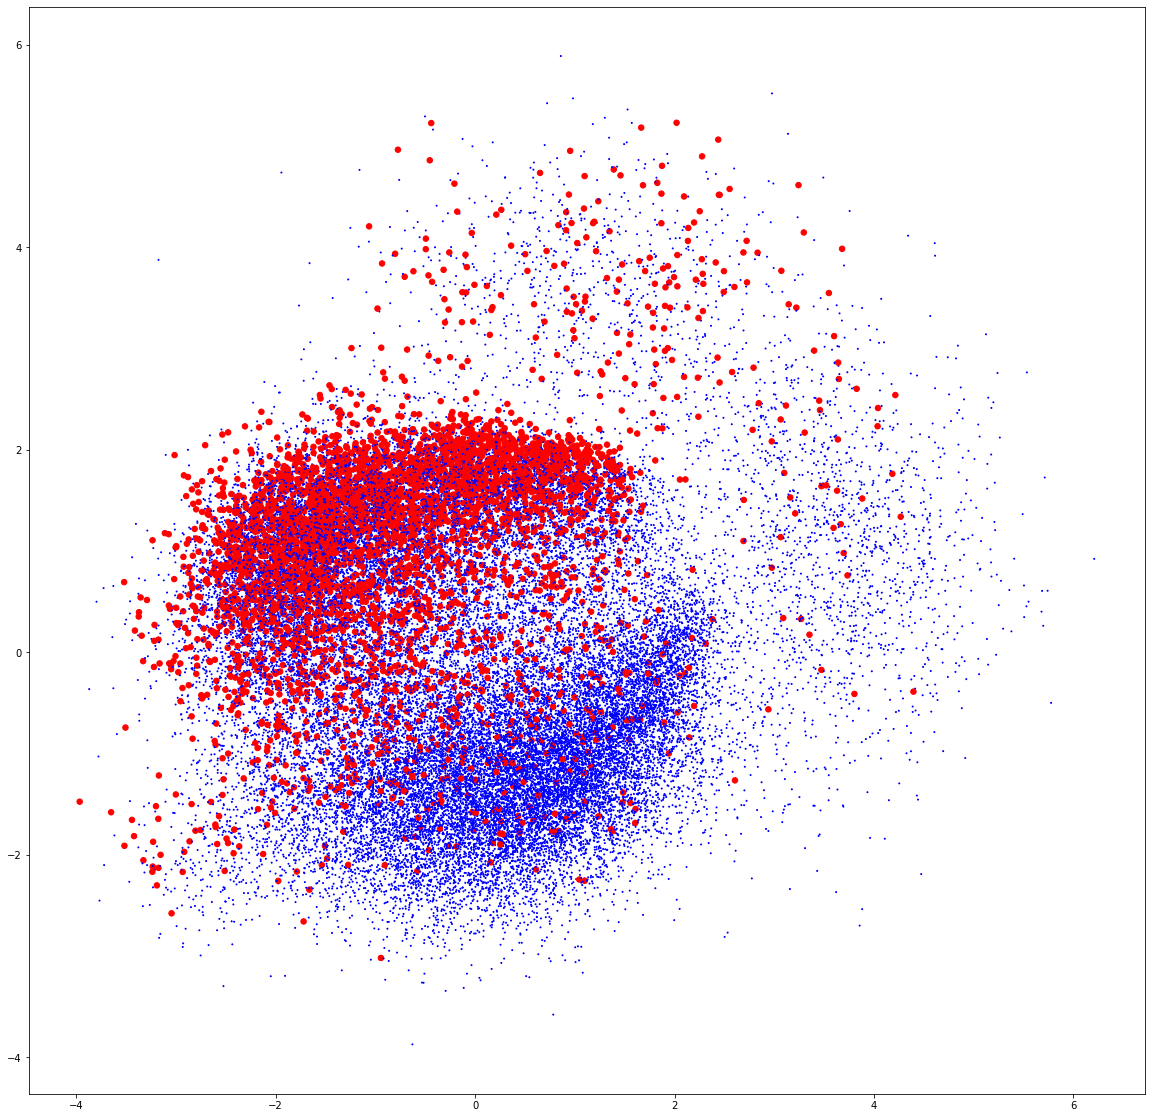

In [17]:
X2 = PCA(n_components=2).fit_transform(embs_arr)
plt.figure(figsize=(20, 20))
colors = ['b'] * num_products
s = [1] * num_products
for i, product in product_mapping["name_by_index"].items():
    if "Organic" in product:
        colors[i] = 'r'
        s[i] = 30
plt.scatter(X2[:,0], X2[:,1], c=colors, s=s)

Như vậy, kết quả minh họa cho thấy có hai nhóm sản phẩm lớn và các sản phẩm có từ "Organic" (màu đỏ) dương như phân bố gần nhau ở phía trên bên trái.


### Độ dài của vector embedding

Khi tính độ tương tự của các embedding, phép toán được sử dụng nhiều nhất là tích vô hướng. Tích này bị ảnh hưởng bởi độ lớn của các vector embdding. Ta cùng thử minh họa độ lớn của các embedding theo tần suất xuất hiện của sản phẩm tương ứng trong các đơn hàng.

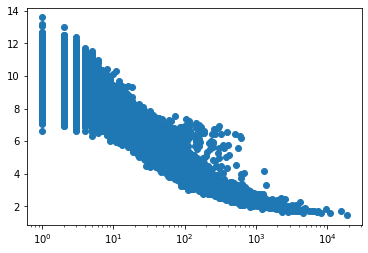

In [18]:
norm = np.sqrt((embs_arr**2).sum(axis=1))

product_freq = Counter([product for order in indexed_orders for product in order])
freqs = [0]*len(product_freq)
for product_index, freq in product_freq.items():
    freqs[product_index] = freq

fig = plt.figure()
ax = plt.gca()
ax.scatter(freqs , norm)
ax.set_xscale('log')

Nhận thấy rằng những sản phẩm có tần suất thấp có độ dài vector embedding lớn hơn các sản phẩm xuất hiện thường xuyên.
Điều này có thể được lý giải bởi thực tế rằng số lượng các mẫu huấn luyện mà chúng là sản phẩm đích ít. Kéo theo đó, số lần cập nhật cho các sản phẩm này rất ít và có thể chúng chưa đạt tới trạng thái tối ưu.

Việc này có thể gây ra sai số khi dùng tích vô hướng làm phép đo độ tương tự. Các sản phẩm có độ dài lớn sẽ "gần" với rất nhiều các sản phẩm khác mặc dù thực tế không như vậy. Để giải quyết vấn đề này, ta có thể thêm `max_norm` khi khai báo [`torch.nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) hoặc `weight_decay` vào optimizer để đảm bảo các trọng số của mà trận embedding không quá lớn.

## Thảo luận

Bạn đọc có thể thí nghiệm thêm với các hướng sau:

* Huấn luyện với toàn bộ dữ liệu của tập Instacart bằng cách sử dụng thêm dữ liệu đơn hàng ở [order_products__prior.csv](https://github.com/tiepvupsu/tabml_data/blob/master/instacart/order_products__prior.csv).

* Có những cách xử lý đặc biệt với những sản phẩm hiếm, ví dụ loại bỏ hoặc đặt chung chúng về một sản phẩm "<UNKNOWN>".
    
* Sử dụng [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) để minh họa embedding thu được trong không gian hai hoặc ba chiều. tSNE được sử dụng nhiều hơn PCA khi minh họa embedding, tuy nhiên nó sẽ mất thời gian hơn.
    
* Lấy mẫu các sản phẩm dương với trọng số khác nhau. Việc này tương tự như với việc lấy mẫu thấp hơn với các từ "stop words" trong ngôn ngữ.
    
## Tài liệu tham khảo
    
[Word Embedding (word2vec), Dive into Deep Learning](http://d2l.ai/chapter_natural-language-processing-pretraining/word2vec.html)

[3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)